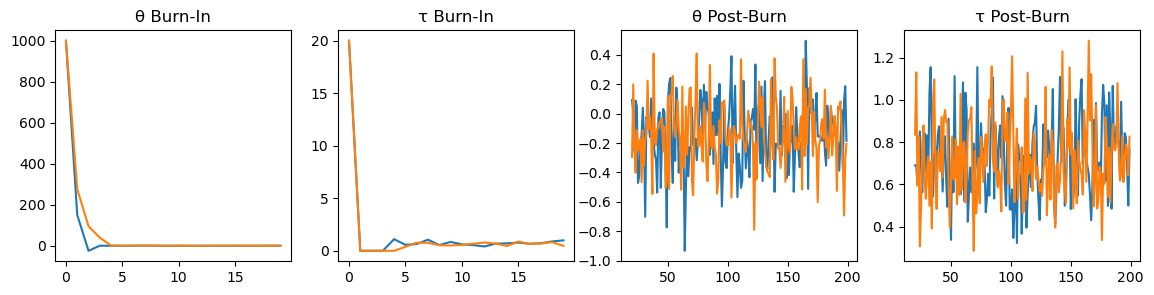

In [1]:
# Q1
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
n = 30
m = 0  
s = 1  
x = stats.norm(loc=m, scale=s).rvs(size=n)

# Gibbs 
C, G = 2, 10000 
theta, tau = np.zeros((C, G)), np.zeros((C, G))
theta[:, 0] = 1000  
tau[:, 0] = 20
for c in range(C):
    for g in range(1, G):
        # τ | θ 
        sum_sq = ((x - theta[c, g-1])**2).sum()
        shape_tau = n / 2 + 1  
        rate_tau = sum_sq / 2
        tau[c, g] = stats.gamma(a=shape_tau, scale=1/rate_tau).rvs()  
        # θ | τ 
        theta_mean = x.mean()
        theta_std = 1 / np.sqrt(tau[c, g] * n)
        theta[c, g] = stats.norm(loc=theta_mean, scale=theta_std).rvs()

# Visualization 
burn = 20  
demo = 200  
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title("θ Burn-In")
ax[1].set_title("τ Burn-In")
ax[2].set_title("θ Post-Burn")
ax[3].set_title("τ Post-Burn")

# Plot
for c in range(C):
    ax[0].plot(theta[c, :burn], label=f"Chain {c}")
    ax[1].plot(tau[c, :burn], label=f"Chain {c}")
    ax[2].plot(np.arange(burn, demo), theta[c, burn:demo])
    ax[3].plot(np.arange(burn, demo), tau[c, burn:demo])


In [14]:
print(f"True θ = {m}, Estimated θ = {np.mean(theta_samples):.3f} (95% CI: {np.quantile(theta_samples, [0.025, 0.975])})")
print(f"True σ = {s}, Estimated σ = {np.mean(sigmas):.3f} (95% CI: {np.quantile(sigmas, [0.025, 0.975])})")

True θ = 0, Estimated θ = 0.541 (95% CI: [0.34116345 0.75413832])
True σ = 1, Estimated σ = 1.003 (95% CI: [0.89956439 1.11985718])


### Full Conditional Distributions

#### Conditional Distribution of $ \tau $

We start with the joint posterior for $ \tau $, which is proportional to the prior and likelihood:
$$
p(\tau \mid \theta, \mathbf{x}) \propto p(\tau) \cdot p(\mathbf{x} \mid \theta, \tau)
$$

The prior for $ \tau $ is a Gamma distribution:
$$
p(\tau) \propto \tau^{\frac{\alpha}{2} - 1} e^{-\frac{\lambda}{2} \tau}
$$

The likelihood $ p(\mathbf{x} \mid \theta, \tau) $ for $ n $ independent observations is:
$$
p(\mathbf{x} \mid \theta, \tau) \propto \prod_{i=1}^n \tau^{1/2} e^{-\frac{\tau}{2}(x_i - \theta)^2}
$$

Combining these:
$$
p(\tau \mid \theta, \mathbf{x}) \propto \tau^{\frac{\alpha}{2} - 1} e^{-\frac{\lambda}{2} \tau} \cdot \tau^{n/2} e^{-\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2}
$$

Simplify the exponents:
$$
p(\tau \mid \theta, \mathbf{x}) \propto \tau^{\frac{\alpha + n}{2} - 1} e^{-\frac{\tau}{2} \left( \lambda + \sum_{i=1}^n (x_i - \theta)^2 \right)}
$$

This is a Gamma distribution:
$$
p(\tau \mid \theta, \mathbf{x}) \sim \text{Gamma}\left(\frac{\alpha + n}{2}, \frac{\lambda + \sum_{i=1}^n (x_i - \theta)^2}{2}\right)
$$

---

#### Conditional Distribution of $ \theta $

We start with the joint posterior for $ \theta $, which is proportional to the prior and likelihood:
$$
p(\theta \mid \tau, \mathbf{x}) \propto p(\theta) \cdot p(\mathbf{x} \mid \theta, \tau)
$$

The prior for $ \theta $ is a Gaussian distribution:
$$
p(\theta) \propto e^{-\frac{\tau_0}{2} (\theta - \theta_0)^2}
$$

The likelihood $ p(\mathbf{x} \mid \theta, \tau) $ is:
$$
p(\mathbf{x} \mid \theta, \tau) \propto e^{-\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2}
$$

Combining these:
$$
p(\theta \mid \tau, \mathbf{x}) \propto e^{-\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2} \cdot e^{-\frac{\tau_0}{2} (\theta - \theta_0)^2}
$$

Expand the quadratic terms:
$$
-\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2 = -\frac{\tau}{2} \left[ \sum_{i=1}^n x_i^2 - 2\theta \sum_{i=1}^n x_i + n\theta^2 \right]
$$
$$
-\frac{\tau_0}{2} (\theta - \theta_0)^2 = -\frac{\tau_0}{2} \left[ \theta^2 - 2\theta \theta_0 + \theta_0^2 \right]
$$

Combine $ \theta $ terms:
$$
p(\theta \mid \tau, \mathbf{x}) \propto e^{-\frac{1}{2} \left[ (\tau_0 + n\tau) \theta^2 - 2\theta (\tau_0 \theta_0 + \tau \sum_{i=1}^n x_i) \right]}
$$

Complete the square:
$$
p(\theta \mid \tau, \mathbf{x}) \propto e^{-\frac{\tau_0 + n\tau}{2} \left( \theta - \frac{\tau_0 \theta_0 + \tau \sum_{i=1}^n x_i}{\tau_0 + n\tau} \right)^2}
$$

This is a Normal distribution:
$$
p(\theta \mid \tau, \mathbf{x}) \sim \text{N}\left(\frac{\tau_0 \theta_0 + \tau \sum_{i=1}^n x_i}{\tau_0 + n\tau}, \frac{1}{\tau_0 + n\tau}\right)
$$


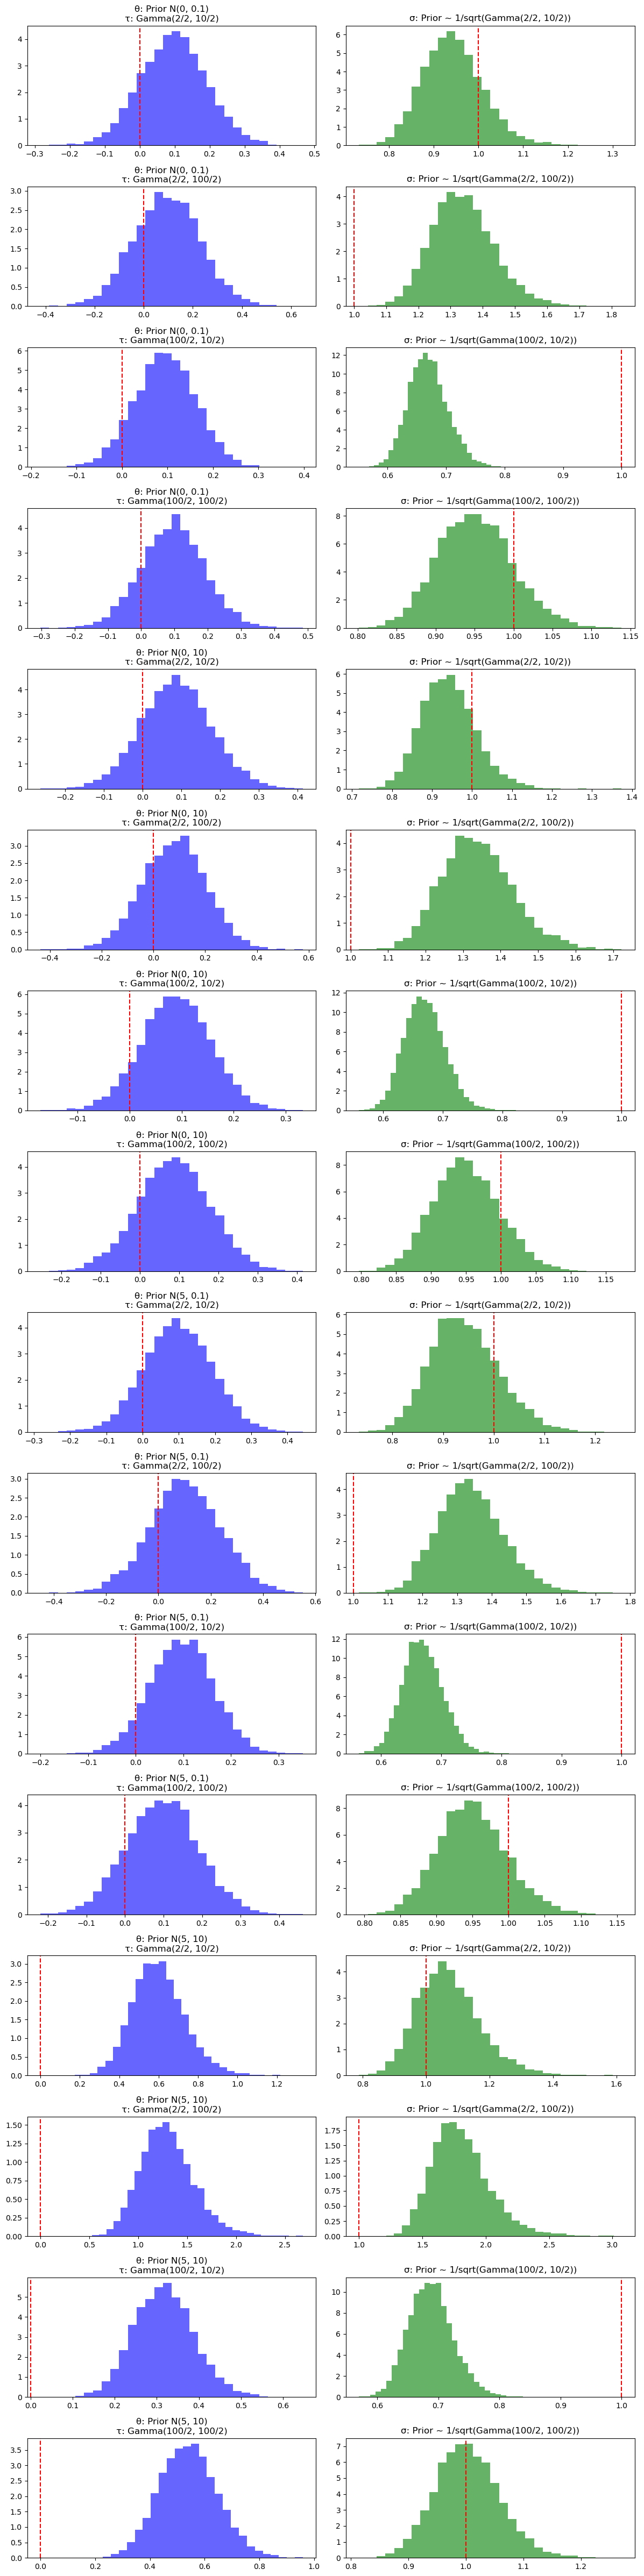

In [9]:
# Q2
import itertools
def gibbs_sampler(x, theta_0, tau_0, alpha, lambda_, chains=2, gibbs_samples=5000, burn_in=1000):
    n = len(x)
    x_mean = np.mean(x)
    theta = np.zeros((chains, gibbs_samples))
    tau = np.zeros((chains, gibbs_samples))
    theta[:, 0] = theta_0
    for c in range(chains):
        for g in range(1, gibbs_samples):
            sum_sq = np.sum((x - theta[c, g-1])**2)
            # τ
            shape_tau = (n + alpha) / 2
            rate_tau = (sum_sq + lambda_) / 2
            tau[c, g] = stats.gamma(a=shape_tau, scale=1/rate_tau).rvs()
            # θ
            post_prec = tau_0 + n * tau[c, g]
            post_mean = (tau_0 * theta_0 + n * tau[c, g] * x_mean) / post_prec
            theta[c, g] = stats.norm(loc=post_mean, scale=1/np.sqrt(post_prec)).rvs()
    return theta[:, burn_in:], tau[:, burn_in:]

# data
n = 100
true_theta, true_sigma = 0, 1
x = stats.norm(loc=true_theta, scale=true_sigma).rvs(size=n)

# hyperparams
hyperparams = {
    "theta_0": [0, 5],            # Prior mean for θ 
    "tau_0": [0.1, 10],           # Prior precision for θ 
    "alpha": [2, 100],            # Prior shape for τ 
    "lambda_": [10, 100]          # Prior rate for τ 
}

# combinations of hyperparameters
combinations = list(itertools.product(*hyperparams.values()))

# Plot
n_combinations = len(combinations)
fig, axes = plt.subplots(n_combinations, 2, figsize=(12, 3*n_combinations))
plt.subplots_adjust(hspace=0.5)

# Iterate hyperparameters
for i, (theta_0, tau_0, alpha, lambda_) in enumerate(combinations):
    # Run Gibbs
    theta_samples, tau_samples = gibbs_sampler(x, theta_0, tau_0, alpha, lambda_)
    sigmas = 1 / np.sqrt(tau_samples)
    
    # Plot θ 
    axes[i, 0].hist(theta_samples.flatten(), bins=30, density=True, alpha=0.6, color='blue')
    axes[i, 0].axvline(true_theta, color='red', linestyle='--', label='True θ')
    axes[i, 0].set_title(
        f"θ: Prior N({theta_0}, {tau_0})\nτ: Gamma({alpha}/2, {lambda_}/2)"
    )
    
    # Plot σ
    axes[i, 1].hist(sigmas.flatten(), bins=30, density=True, alpha=0.6, color='green')
    axes[i, 1].axvline(true_sigma, color='red', linestyle='--', label='True σ')
    axes[i, 1].set_title(
        f"σ: Prior ~ 1/sqrt(Gamma({alpha}/2, {lambda_}/2))"
    )

plt.tight_layout()
plt.show()

A strong prior (large 𝛼 and 𝜆) dominates the posterior, reflecting prior beliefs, while a weak prior allows the likelihood (data) to drive the inference. This balance means that the prior stabilizes inference in small or noisy datasets, while its influence diminishes as the data size increases.

Q3: In Bayesian inference, we can disregard normalizing constants because the posterior is proportional to the joint distribution (likelihood × prior) per Bayes Theorem, and since constants like the marginal likelihood p(x) do not depend on the parameters θ
θ, they leave the posterior’s shape—and all inferential conclusions about θ, such as credible intervals or relative probabilities—unchanged. When models use conjugate priors, the joint distribution's kernel matches a known distribution family, we can identify the normalized posterior without explicit integration. Even in non-conjugate settings, computational methods  rely on sampling from the unnormalized posterior. This computational method focus on relative beliefs: since inference revolves around comparing parameter plausibility (via posterior densities, intervals, or histograms), scaling becomes irrelevant, and normalization is rendered unnecessary.